In [1]:
#import image_analysis as ia
#import NearestNeighbour as NN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# 1. Image Analysis
Image analysis involves 2 main steps: Segmentation and Object detection
## 1.1 Segmentation
First the images are segemented into individual cells and their boundaries are stored as ImageJ ROIs in zip files. These can be opened later in FIJI/ImageJ vor viewing and analysis.
Segmentation involves the following steps:
1. Thresholding: Images are thresholded by the multiotsu thresholding technique, which produces 2 numbers. The lower number is chosen as a threshold.
2. Cell separation: During thresholding cells may be too close together which would merge them together. To solve this problem Cell centers are identified and starting from the cell centers watershed segmentation is performed. This seperates the thrsholded area into individual labeled regions that represent the cells. Cell centers are identified via either of the following methods:
    - By nuclei: If nuclei were imaged by a DAPI stain, they are identified as cell centers.
    - By distance transform: If no nuclei were captured a distance transform is performed. Resulting peaks are taken as cell centers.
3. Cell identification and measurement: From each cell measurements are taken involving the area, mean and median intensities. Furthermore the boundaries are converted to ROIs and stored in a corresponding zip file.

In [2]:
basedir = "D:/Raphael/Data/3. Plasmid moves cargo into Lysosomes"
df = pd.DataFrame()
#df = pd.read_excel(os.path.join(basedir,"Results.xlsx"))
CD={0:"aSyn-GFP",1:"aSyn-AB",2:"LAMP1/LC3"}
#seg = ia.segmentation(basedir=basedir,p_max=500,t_mod=1,ch_dic=CD,cell_channel="aSyn-GFP",intensity_channels=["aSyn-GFP"])
#print(seg.ch_dic)
#seg.plot_segmentation()
#seg.segment_all()
#df.head()

In [3]:
df = pd.read_excel(os.path.join(basedir,"Results.xlsx"))
df = df[df["Group2"]=="LC3"]
df.head()

,Unnamed: 0,label,bbox-0,bbox-1,bbox-2,bbox-3,label_aSyn-GFP,bbox-0_aSyn-GFP,bbox-1_aSyn-GFP,bbox-2_aSyn-GFP,...,Channel_1,Channel_aSyn-AB,Channel_2,Channel_LAMP1/LC3,ROI_path,Replicate,Group1,Group2,path,denoised_path
13,13,6,822,779,1571,1236,6,822,779,1571,...,aSyn-AB,1,LAMP1/LC3,2,D:/Raphael/Data/3. Plasmid moves cargo into Ly...,1,FY,LC3,D:/Raphael/Data/3. Plasmid moves cargo into Ly...,D:/Raphael/Data/3. Plasmid moves cargo into Ly...
14,14,9,690,888,1533,1726,9,690,888,1533,...,aSyn-AB,1,LAMP1/LC3,2,D:/Raphael/Data/3. Plasmid moves cargo into Ly...,1,FY,LC3,D:/Raphael/Data/3. Plasmid moves cargo into Ly...,D:/Raphael/Data/3. Plasmid moves cargo into Ly...
15,15,6,690,164,1382,788,6,690,164,1382,...,aSyn-AB,1,LAMP1/LC3,2,D:/Raphael/Data/3. Plasmid moves cargo into Ly...,1,FY,LC3,D:/Raphael/Data/3. Plasmid moves cargo into Ly...,D:/Raphael/Data/3. Plasmid moves cargo into Ly...
16,16,7,813,1096,1433,1442,7,813,1096,1433,...,aSyn-AB,1,LAMP1/LC3,2,D:/Raphael/Data/3. Plasmid moves cargo into Ly...,1,FY,LC3,D:/Raphael/Data/3. Plasmid moves cargo into Ly...,D:/Raphael/Data/3. Plasmid moves cargo into Ly...
17,17,8,871,783,1427,1100,8,871,783,1427,...,aSyn-AB,1,LAMP1/LC3,2,D:/Raphael/Data/3. Plasmid moves cargo into Ly...,1,FY,LC3,D:/Raphael/Data/3. Plasmid moves cargo into Ly...,D:/Raphael/Data/3. Plasmid moves cargo into Ly...


In [4]:
from Manders import manders, adapted_manders,manders_overlap
from ImageOperations import get_cropped, getImage, get_mask
from skimage.filters import threshold_otsu,threshold_multiotsu
from skimage.measure import pearson_corr_coeff
from tqdm import tqdm
def get_coloc(df):
    df2 = pd.DataFrame()
    Rep=[]
    CIDs = []
    Group = []
    Manders_GFP = []
    Manders_AB = []
    Manders_adapted_GFP = []
    Manders_adapted_AB = []
    Pearson_GFP = []
    Pearson_AB = []
    Ratio_GFP = []
    Ratio_AB = []
    Ratio_LC3 = []
    Stack = []
    for CID in tqdm(df["CID"].values):
        denoised_path = df[df["CID"]==CID]["denoised_path"].values[0]
        image1_GFP = getImage(denoised_path,0)
        image1_AB = getImage(denoised_path,1)
        image1_LC3 = getImage(denoised_path,2)
        image2_GFP = get_cropped(df,CID,0)
        image2_AB = get_cropped(df,CID,1)
        image2_LC3 = get_cropped(df,CID,2)
        mask = get_mask(df,CID,image1_GFP[0,:,:].shape)
        t_GFP = threshold_otsu(image1_GFP[:,mask==True])
        t_AB = threshold_otsu(image1_AB[:,mask==True])
        t_LC3 = threshold_otsu(image1_LC3[:,mask==True])
        image1_GFP[:,mask==False] = 0
        image1_AB[:,mask==False] = 0
        image1_LC3[:,mask==False] = 0
        for i in range(image1_GFP.shape[0]):
            Manders_GFP.append(manders(image2_GFP[i,:,:],image1_LC3[i,:,:]>t_LC3,mask))
            Manders_AB.append(manders(image2_LC3[i,:,:],image1_GFP[i,:,:]>t_GFP,mask))
            Manders_adapted_GFP.append(manders(image2_AB[i,:,:],image1_LC3[i,:,:]>t_LC3,mask))
            Manders_adapted_AB.append(manders(image2_LC3[i,:,:],image1_AB[i,:,:]>t_AB,mask))
            Pearson_GFP.append(pearson_corr_coeff(image1_AB[i,:,:],image1_LC3[i,:,:]))
            Pearson_AB.append(pearson_corr_coeff(image1_GFP[i,:,:],image1_LC3[i,:,:]))
            Group.append(df[df["CID"]==CID]["Group1"].values[0])
            Rep.append(df[df["CID"]==CID]["Replicate"].values[0])
            Stack.append(i)
            CIDs.append(CID)
            Ratio_GFP.append(np.sum(image1_GFP[i,:,:]>t_GFP)/np.sum(mask))
            Ratio_AB.append(np.sum(image1_AB[i,:,:]>t_GFP)/np.sum(mask))
            Ratio_LC3.append(np.sum(image1_LC3[i,:,:]>t_GFP)/np.sum(mask))
    df2["Manders_GFP_M1"] = Manders_GFP
    df2["Manders_GFP_M2"] = Manders_AB
    df2["Manders_AB_M1"] = Manders_adapted_GFP
    df2["Manders_AB_M2"] = Manders_adapted_AB
    df2["Ratio_GFP"] = Ratio_GFP
    df2["Ratio_AB"] = Ratio_AB
    df2["Ratio_LC3"] = Ratio_LC3
    df2["Pearson_GFP"] = Manders_adapted_AB
    df2["Pearson_AB"] = Manders_adapted_AB
    df2["Replicate"] = Rep
    df2["Group1"] = Group
    df2["CID"] = CIDs
    df2["Stack"] = Stack
    return df2

#df2 = get_coloc(df)

In [5]:
from ImageOperations import get_cropped, getImage, get_mask, get_ROI
from Ripley import ripley
from DetectPoints import detect_points
from tqdm import tqdm
def get_R(lower,upper):
    xlen = 0.0753084
    r = np.linspace(lower/xlen,upper/xlen,100)
    return r

def calculate_ripley(df,R):
    data = {
        "L":[],
        "r":[],
        "X":[],
        "Y":[],
        "Group":[],
        "Stack":[],
        "CID":[],
        "Rep":[],
        "LenX":[],
        "LenY":[]
    }
    for CID in tqdm(df["CID"].values):
        rep = df[df["CID"]==CID]["Replicate"].values[0]
        g = df[df["CID"]==CID]["Group1"].values[0]
        ROI = get_ROI(df,CID)
        GFPimage = get_cropped(df,CID,0).astype("uint8")
        ABimage = get_cropped(df,CID,1).astype("uint8")
        LC3image = get_cropped(df,CID,2).astype("uint8")
        boundary = ROI.coordinates()-[[ROI.left,ROI.top]]
        for i in range(GFPimage.shape[0]):
            GFP = detect_points(GFPimage[i,:,:],ROI,ntol=50)
            AB = detect_points(ABimage[i,:,:],ROI,ntol=50)
            LC3 = detect_points(LC3image[i,:,:],ROI,ntol=200)
            #GFP - LC3
            if len(GFP) != 0 and len(LC3) != 0:
                data["L"]=[*data["L"],*ripley(GFP,LC3,boundary,R,maxD=np.max(R))]
                data["r"]=[*data["r"],*R]
                data["X"]=[*data["X"],*(["GFP"]*len(R))]
                data["Y"]=[*data["Y"],*(["LC3"]*len(R))]
                data["CID"]=[*data["CID"],*([CID]*len(R))]
                data["Rep"]=[*data["Rep"],*([rep]*len(R))]
                data["Stack"]=[*data["Stack"],*([i]*len(R))]
                data["Group"]=[*data["Group"],*([g]*len(R))]
                data["LenX"]=[*data["LenX"],*([len(GFP)]*len(R))]
                data["LenY"]=[*data["LenY"],*([len(LC3)]*len(R))]
            #AB - LC3
            if len(AB) != 0 and len(LC3) != 0:
                data["L"]=[*data["L"],*ripley(AB,LC3,boundary,R,maxD=np.max(R))]
                data["r"]=[*data["r"],*R]
                data["X"]=[*data["X"],*(["AB"]*len(R))]
                data["Y"]=[*data["Y"],*(["LC3"]*len(R))]
                data["CID"]=[*data["CID"],*([CID]*len(R))]
                data["Rep"]=[*data["Rep"],*([rep]*len(R))]
                data["Group"]=[*data["Group"],*([g]*len(R))]
                data["Stack"]=[*data["Stack"],*([i]*len(R))]
                data["LenX"]=[*data["LenX"],*([len(AB)]*len(R))]
                data["LenY"]=[*data["LenY"],*([len(LC3)]*len(R))]
            #LC3 - GFP
            if len(GFP) != 0 and len(LC3) != 0:
                data["L"]=[*data["L"],*ripley(LC3,GFP,boundary,R,maxD=np.max(R))]
                data["r"]=[*data["r"],*R]
                data["X"]=[*data["X"],*(["LC3"]*len(R))]
                data["Y"]=[*data["Y"],*(["GFP"]*len(R))]
                data["CID"]=[*data["CID"],*([CID]*len(R))]
                data["Rep"]=[*data["Rep"],*([rep]*len(R))]
                data["Group"]=[*data["Group"],*([g]*len(R))]
                data["Stack"]=[*data["Stack"],*([i]*len(R))]
                data["LenX"]=[*data["LenX"],*([len(LC3)]*len(R))]
                data["LenY"]=[*data["LenY"],*([len(GFP)]*len(R))]
            #LC3 - AB
            if len(AB) != 0 and len(LC3) != 0:
                data["L"]=[*data["L"],*ripley(LC3,AB,boundary,R,maxD=np.max(R))]
                data["r"]=[*data["r"],*R]
                data["X"]=[*data["X"],*(["LC3"]*len(R))]
                data["Y"]=[*data["Y"],*(["AB"]*len(R))]
                data["CID"]=[*data["CID"],*([CID]*len(R))]
                data["Rep"]=[*data["Rep"],*([rep]*len(R))]
                data["Group"]=[*data["Group"],*([g]*len(R))]
                data["Stack"]=[*data["Stack"],*([i]*len(R))]
                data["LenX"]=[*data["LenX"],*([len(LC3)]*len(R))]
                data["LenY"]=[*data["LenY"],*([len(AB)]*len(R))]
    return pd.DataFrame(data=data)

R = get_R(0,0.5)
#df2 = calculate_ripley(df,R)
#df2.to_csv(os.path.join(basedir,"LC3_Ripley_coloc.csv"),index=False)
#df2.head()

In [6]:
from ImageOperations import get_cropped, getImage, get_mask, get_ROI
from NearestNeighbour import NearestNeighbour
from DetectPoints import detect_points
from tqdm import tqdm
def get_R(lower,upper):
    xlen = 0.0753084
    r = np.linspace(lower/xlen,upper/xlen,100)
    return r

def calculate_NN(df,R):
    data = {
        "L":[],
        "r":[],
        "X":[],
        "Y":[],
        "Group":[],
        "Stack":[],
        "CID":[],
        "Rep":[],
        "LenX":[],
        "LenY":[]
    }
    for CID in tqdm(df["CID"].values):
        rep = df[df["CID"]==CID]["Replicate"].values[0]
        g = df[df["CID"]==CID]["Group1"].values[0]
        ROI = get_ROI(df,CID)
        GFPimage = get_cropped(df,CID,0).astype("uint8")
        ABimage = get_cropped(df,CID,1).astype("uint8")
        LC3image = get_cropped(df,CID,2).astype("uint8")
        boundary = ROI.coordinates()-[[ROI.left,ROI.top]]
        for i in range(GFPimage.shape[0]):
            GFP = detect_points(GFPimage[i,:,:],ROI,ntol=50)
            AB = detect_points(ABimage[i,:,:],ROI,ntol=50)
            LC3 = detect_points(LC3image[i,:,:],ROI,ntol=200)
            #GFP - LC3
            if len(GFP) != 0 and len(LC3) != 0:
                data["L"]=[*data["L"],*NearestNeighbour(GFP,LC3,boundary,R,maxD=np.max(R))]
                data["r"]=[*data["r"],*R]
                data["X"]=[*data["X"],*(["GFP"]*len(R))]
                data["Y"]=[*data["Y"],*(["LC3"]*len(R))]
                data["CID"]=[*data["CID"],*([CID]*len(R))]
                data["Rep"]=[*data["Rep"],*([rep]*len(R))]
                data["Stack"]=[*data["Stack"],*([i]*len(R))]
                data["Group"]=[*data["Group"],*([g]*len(R))]
                data["LenX"]=[*data["LenX"],*([len(GFP)]*len(R))]
                data["LenY"]=[*data["LenY"],*([len(LC3)]*len(R))]
            #AB - LC3
            if len(AB) != 0 and len(LC3) != 0:
                data["L"]=[*data["L"],*NearestNeighbour(AB,LC3,boundary,R,maxD=np.max(R))]
                data["r"]=[*data["r"],*R]
                data["X"]=[*data["X"],*(["AB"]*len(R))]
                data["Y"]=[*data["Y"],*(["LC3"]*len(R))]
                data["CID"]=[*data["CID"],*([CID]*len(R))]
                data["Rep"]=[*data["Rep"],*([rep]*len(R))]
                data["Group"]=[*data["Group"],*([g]*len(R))]
                data["Stack"]=[*data["Stack"],*([i]*len(R))]
                data["LenX"]=[*data["LenX"],*([len(AB)]*len(R))]
                data["LenY"]=[*data["LenY"],*([len(LC3)]*len(R))]
            #LC3 - GFP
            if len(GFP) != 0 and len(LC3) != 0:
                data["L"]=[*data["L"],*NearestNeighbour(LC3,GFP,boundary,R,maxD=np.max(R))]
                data["r"]=[*data["r"],*R]
                data["X"]=[*data["X"],*(["LC3"]*len(R))]
                data["Y"]=[*data["Y"],*(["GFP"]*len(R))]
                data["CID"]=[*data["CID"],*([CID]*len(R))]
                data["Rep"]=[*data["Rep"],*([rep]*len(R))]
                data["Group"]=[*data["Group"],*([g]*len(R))]
                data["Stack"]=[*data["Stack"],*([i]*len(R))]
                data["LenX"]=[*data["LenX"],*([len(LC3)]*len(R))]
                data["LenY"]=[*data["LenY"],*([len(GFP)]*len(R))]
            #LC3 - AB
            if len(AB) != 0 and len(LC3) != 0:
                data["L"]=[*data["L"],*NearestNeighbour(LC3,AB,boundary,R,maxD=np.max(R))]
                data["r"]=[*data["r"],*R]
                data["X"]=[*data["X"],*(["LC3"]*len(R))]
                data["Y"]=[*data["Y"],*(["AB"]*len(R))]
                data["CID"]=[*data["CID"],*([CID]*len(R))]
                data["Rep"]=[*data["Rep"],*([rep]*len(R))]
                data["Group"]=[*data["Group"],*([g]*len(R))]
                data["Stack"]=[*data["Stack"],*([i]*len(R))]
                data["LenX"]=[*data["LenX"],*([len(LC3)]*len(R))]
                data["LenY"]=[*data["LenY"],*([len(AB)]*len(R))]
    return pd.DataFrame(data=data)

R = get_R(0,0.5)
df2 = calculate_NN(df,R)
df2.to_csv(os.path.join(basedir,"LC3_NN_coloc.csv"),index=False)
df2.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [19:10<00:00, 14.75s/it]


,L,r,X,Y,Group,Stack,CID,Rep,LenX,LenY
0,0.0,0.000000,AB,LC3,FY,0,54,1,1,2
1,0.0,0.067064,AB,LC3,FY,0,54,1,1,2
2,0.0,0.134129,AB,LC3,FY,0,54,1,1,2
3,0.0,0.201193,AB,LC3,FY,0,54,1,1,2
4,0.0,0.268257,AB,LC3,FY,0,54,1,1,2


In [7]:
df2["r"] = df2["r"]*0.0753084

C:\Users\Raphael\AppData\Local\Temp\ipykernel_18336\83983210.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = df2[df2["X"]=="AB"][df2["Y"]=="LC3"]


<AxesSubplot:xlabel='Group', ylabel='LenY'>

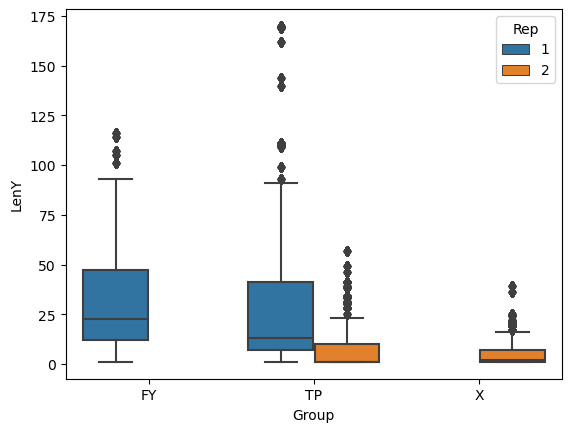

In [22]:
df3 = df2[df2["X"]=="AB"][df2["Y"]=="LC3"]
import seaborn as sns
sns.boxplot(data=df3,x = "Group",y="LenY",hue="Rep")

<AxesSubplot:xlabel='r', ylabel='L'>

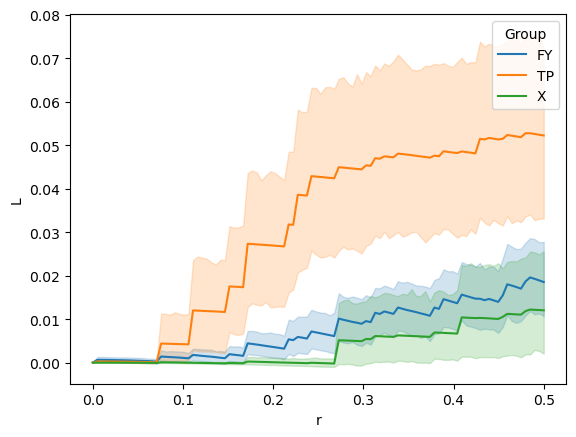

In [17]:

sns.lineplot(data=df3, x="r",y="L",hue="Group")

In [18]:
gdf = pd.concat([df3.groupby(["CID","Stack"])["L"].sum(),df3.groupby(["CID","Stack"])["Group"].first()],axis=1)
gdf.head()

L Group
CID Stack                
54  0     -0.053966    FY
    1     -0.110210    FY
    2     -0.584206    FY
    3     -1.050287    FY
    4     -0.596833    FY

In [35]:
df4 = pd.concat([df3.groupby(["CID","Stack"])["L","r"].apply(lambda x: np.interp(0.25,x["r"],x["L"])),df3.groupby(["CID","Stack"])["Group"].first()],axis=1).rename(columns= {0:'%'}).dropna()
df4.head()

C:\Users\Raphael\AppData\Local\Temp\ipykernel_18336\211226237.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df4 = pd.concat([df3.groupby(["CID","Stack"])["L","r"].apply(lambda x: np.interp(0.25,x["r"],x["L"])),df3.groupby(["CID","Stack"])["Group"].first()],axis=1).rename(columns= {0:'%'}).dropna()


% Group
CID Stack                
54  0     -0.000167    FY
    1     -0.001089    FY
    2     -0.000499    FY
    3     -0.002001    FY
    4     -0.001180    FY

<AxesSubplot:xlabel='Group', ylabel='%'>

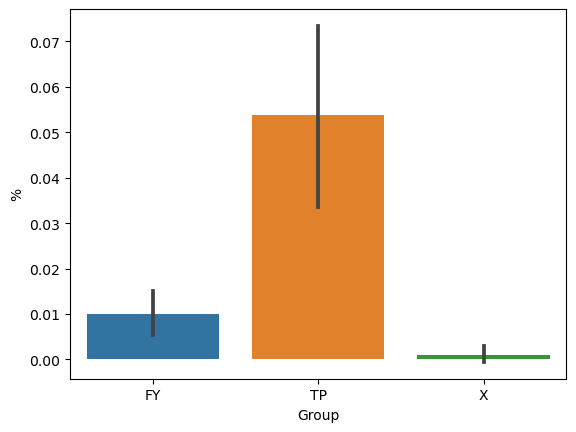

In [36]:
sns.barplot(data=df4,x = "Group",y="%")

In [37]:
import scipy.stats as stats

# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(df4[df4["Group"]=="X"]['%'].dropna(), df4[df4["Group"]=="TP"]['%'].dropna(), df4[df4["Group"]=="FY"]['%'].dropna())
print(fvalue, pvalue)

13.899040309469582 1.1874917169391108e-06


In [38]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

m_comp = pairwise_tukeyhsd(endog=df4['%'].dropna(), groups=df4['Group'].dropna(), alpha=0.05)
m_comp.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
FY,TP,0.0438,0.0016,0.0141,0.0735,True
FY,X,-0.009,0.7711,-0.0397,0.0217,False
TP,X,-0.0528,0.0,-0.0777,-0.0279,True


In [41]:
df5 = df2[df2["X"]=="LC3"][df2["Y"]=="AB"]

C:\Users\Raphael\AppData\Local\Temp\ipykernel_18336\1371556776.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df5 = df2[df2["X"]=="LC3"][df2["Y"]=="AB"]


In [42]:
df6 = pd.concat([df5.groupby(["CID","Stack"])["L","r"].apply(lambda x: np.interp(0.25,x["r"],x["L"])),df5.groupby(["CID","Stack"])["Group"].first()],axis=1).rename(columns= {0:'%'}).dropna()
df6.head()

C:\Users\Raphael\AppData\Local\Temp\ipykernel_18336\1682409247.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df6 = pd.concat([df5.groupby(["CID","Stack"])["L","r"].apply(lambda x: np.interp(0.25,x["r"],x["L"])),df5.groupby(["CID","Stack"])["Group"].first()],axis=1).rename(columns= {0:'%'}).dropna()


% Group
CID Stack                
54  0     -0.000491    FY
    1     -0.000676    FY
    2     -0.004406    FY
    3     -0.008016    FY
    4     -0.010333    FY

<AxesSubplot:xlabel='Group', ylabel='%'>

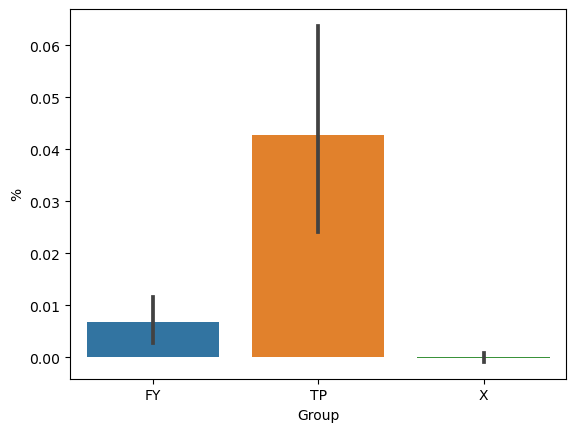

In [43]:
sns.barplot(data=df6,x = "Group",y="%")

In [44]:
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(df6[df6["Group"]=="X"]['%'].dropna(), df6[df6["Group"]=="TP"]['%'].dropna(), df6[df6["Group"]=="FY"]['%'].dropna())
print(fvalue, pvalue)

10.577186510434764 2.9579533682441205e-05


In [45]:
m_comp = pairwise_tukeyhsd(endog=df6['%'].dropna(), groups=df6['Group'].dropna(), alpha=0.05)
m_comp.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
FY,TP,0.0359,0.0067,0.0082,0.0635,True
FY,X,-0.0069,0.8367,-0.0356,0.0217,False
TP,X,-0.0428,0.0,-0.066,-0.0196,True


C:\Users\Raphael\anaconda3\envs\pathophysiology\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 28.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='Group', ylabel='%'>

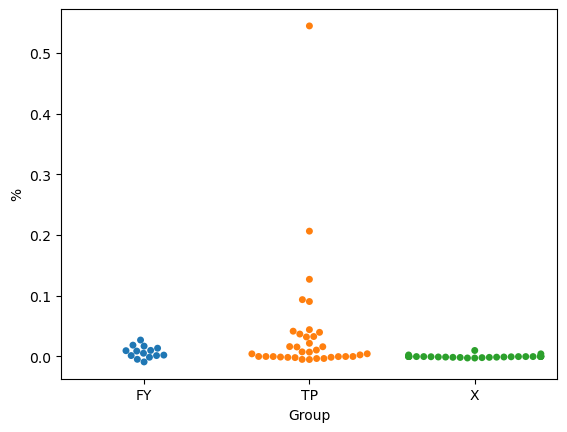

In [46]:
df7 = pd.concat([df6.groupby(["CID"])["%"].mean(numeric_only=True),df6.groupby(["CID"])["Group"].first()],axis=1)
df7.head()
sns.swarmplot(data=df7,x = "Group",y="%")

KeyError: 'Group1'

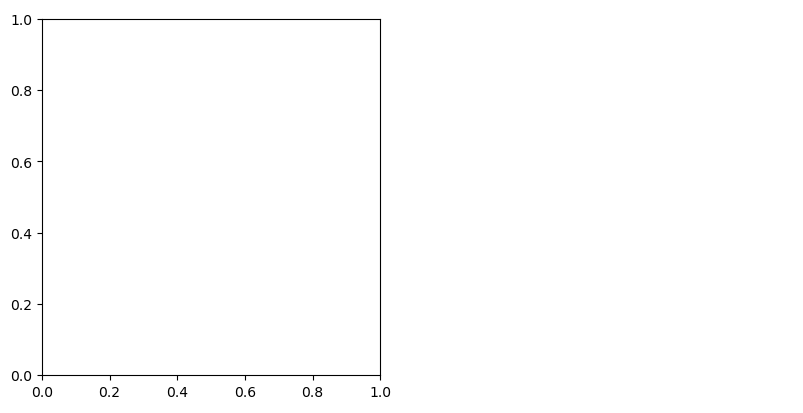

In [47]:
import pathophys as pp

def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

def drawsigbars(ax, ctrl, treatment, maxv, y_range, diff,pv):
    import matplotlib.pyplot as plt
    import pathophys as pp
    ctrls = ctrl
    treatments = treatment
    if (type(ctrl) is dict) == True:
        ctrls = list(ctrl.keys())[0]
        ctrl = ctrl[ctrls]
        treatments = list(treatment.keys())[0]
        treatment = treatment[treatments]
        print(ctrl)
    ax.plot(
        [ctrl, ctrl, treatment, treatment],
        [maxv, maxv, maxv, maxv], lw=2, c='k'
    )
    p = pp.convert_pvalue_to_asterisks(pv)
    ax.text((ctrl+diff), maxv, p, ha='center', va='bottom', fontsize=11)

    
pv1 = {
    "Ctrl":{
        "TP":0,
        "FY":0.8367 	
    }
}
pv2 = {
    "Ctrl":{
        "TP":0.7711 	,
        "FY":0
    }
}
sigp = [["Ctrl","TP"],["Ctrl","FY"]]
params = pp.loadparams()
#sns.set_palette(sns.color_palette(params["Colors"]))
bs = params["BarSize"]
ls = params["LS"]
fig = plt.figure(constrained_layout=True, figsize=(20*pp.cm,10*pp.cm))
subfigs = fig.subfigures(1,2)

axUp = subfigs[0].subplots(1, 1, sharey=True)
X2 = []
X3 = []
Y2 = []
maxvs = []
i = 0
for g in ['X','TP', 'FY']:
    gdf = df6[df6["Group"]==g]
    x = g
    if g == "X":
        x = "Ctrl"
    X2.append(x)
    gdf['%'] = gdf['%']*100
    y = gdf['%'].mean()
    std = gdf['%'].std()
    err = 1.96*(std)/np.sqrt(gdf.size)
    maxvs.append(y+err)
    axUp.bar(x, y, 0.8, yerr=err, capsize=4, linewidth=ls, edgecolor="black",color=params["Colors"][i])
    i=i+1
    #CI1.append(1.96*(df["Mean"][df["Group"]==g].std())/math.sqrt(len(df[df["Group"]==g])))
for axis in ['top','bottom','left','right']:
    axUp.spines[axis].set_linewidth(ls)
    if axis in ['top','right']:
        axUp.spines[axis].set_visible(False)
axUp.tick_params(width=ls)
maxv2 = np.max(np.array(maxvs))

bottom2, top2 = axUp.get_ylim()
y_range = top2 - bottom2
hightind =  y_range*0.1
treatmenti = 0
#args = [df["Mean"][df["Group"]==g].values for g in df["Group"].unique()]
#m_comp = tukey_hsd(*args)
for pairs in sigp:
    c1 = pairs[0]
    ctrli = X2.index(c1)
    c2 = pairs[1]
    treatmenti = X2.index(c2)
    c1dic = {c1:ctrli+1}
    c2dic = {c2:treatmenti+1}
    diff = ((treatmenti-ctrli)/2)
    print(diff)
    p = pv1[c1][c2]
    drawsigbars(axUp, ctrli, treatmenti, maxv2+hightind, y_range, diff,p)
    hightind = hightind + y_range*0.2
#expected = ((1.2)**2)/2-((0.2)**2)/2
#axLo.axhline(y=expected, color='r', linestyle='--')
axUp.set_title("Colocalization (aSyn - LC3)", fontsize=11)
axUp.set_title("b", loc="left", fontsize=20, fontweight="bold", pad=15)
axUp.set_xlabel("Treatment", fontsize=11)
axUp.set_ylabel("% aSyn colocalization with LC3 (<0.25 µm)", fontsize=11)

axLo = subfigs[1].subplots(1, 1, sharey=True)
X2 = []
X3 = []
Y2 = []
maxvs = []
i = 0
for g in ['X','TP', 'FY']:
    gdf = df4[df4["Group1"]==g]
    x = g
    if g == "X":
        x = "Ctrl"
    X2.append(x)
    gdf['%'] = gdf['%']*100
    y = gdf['%'].mean()
    std = gdf['%'].std()
    err = 1.96*(std)/np.sqrt(gdf.size)
    maxvs.append(y+err)
    axLo.bar(x, y, 0.8, yerr=err, capsize=4, linewidth=ls, edgecolor="black",color=params["Colors"][i])
    i=i+1
    #CI1.append(1.96*(df["Mean"][df["Group"]==g].std())/math.sqrt(len(df[df["Group"]==g])))
for axis in ['top','bottom','left','right']:
    axLo.spines[axis].set_linewidth(ls)
    if axis in ['top','right']:
        axLo.spines[axis].set_visible(False)
axLo.tick_params(width=ls)
maxv2 = np.max(np.array(maxvs))

bottom2, top2 = axLo.get_ylim()
y_range = top2 - bottom2
hightind =  y_range*0.1
treatmenti = 0
#args = [df["Mean"][df["Group"]==g].values for g in df["Group"].unique()]
#m_comp = tukey_hsd(*args)
for pairs in sigp:
    c1 = pairs[0]
    ctrli = X2.index(c1)
    c2 = pairs[1]
    treatmenti = X2.index(c2)
    c1dic = {c1:ctrli+1}
    c2dic = {c2:treatmenti+1}
    diff = ((treatmenti-ctrli)/2)
    print(diff)
    p = pv2[c1][c2]
    drawsigbars(axLo, ctrli, treatmenti, maxv2+hightind, y_range, diff,p)
    hightind = hightind + y_range*0.2
#expected = ((1.2)**2)/2-((0.2)**2)/2
#axLo.axhline(y=expected, color='r', linestyle='--')
axLo.set_title("Colocalization (LC3 - aSyn)", fontsize=11)
axLo.set_title("c", loc="left", fontsize=20, fontweight="bold", pad=15)
axLo.set_xlabel("Treatment", fontsize=11)
axLo.set_ylabel("% LC3 colocalization with aSyn (<0.25 µm)", fontsize=11)


plt.show()

In [39]:
#from scipy.stats import ttest_ind
#print(ttest_ind(df4[df4["Group"]=="X"]['%'].dropna(),df4[df4["Group"]=="FY"]['%'].dropna()))

Ttest_indResult(statistic=-4.005175706932421, pvalue=7.34918114232137e-05)


In [14]:
#df2.to_excel(os.path.join(basedir,"LC3_Manders.xlsx"),index_label="CID")

In [15]:
import seaborn as sns
sns.boxplot(data=df2,x = "Group1",y="Manders_GFP_M1")

ValueError: Could not interpret input 'Group1'

In [ ]:
sns.boxplot(data=df2,x = "Group1",y="Manders_GFP_M2")

In [ ]:
sns.boxplot(data=df2,x = "Group1",y="Manders_AB_M1")

In [ ]:
sns.boxplot(data=df2,x = "Group1",y="Manders_AB_M2")

In [ ]:
sns.barplot(data=df2,x = "Group1",y="Manders_AB_M1")

In [ ]:
sns.barplot(data=df2,x = "Group1",y="Manders_AB_M2")

In [ ]:
#sns.violinplot(data=df2,x = "Group1",y="Manders_adapted_AB")

In [ ]:
sns.boxplot(data=df2,x = "Group1",y="Pearson_GFP")

In [ ]:
sns.boxplot(data=df2,x = "Group1",y="Pearson_AB",hue="Replicate")

In [ ]:
df2.groupby("Group1")['Manders_AB_M1'].mean()

In [ ]:
import scipy.stats as stats
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(df2[df2["Group1"]=="X"]['Manders_AB_M1'], df2[df2["Group1"]=="TP"]['Manders_AB_M1'], df2[df2["Group1"]=="FY"]['Manders_AB_M1'])
print(fvalue, pvalue)

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

m_comp = pairwise_tukeyhsd(endog=df2['Manders_AB_M1'].dropna(), groups=df2['Group1'], alpha=0.05)
m_comp.summary()

In [ ]:
sns.barplot(data=df2,x = "Group1",y="Manders_AB_M1",hue="Replicate")

In [ ]:
df2.groupby("Group1")['Manders_GFP_M2'].mean()

In [ ]:
import scipy.stats as stats
df2 = df2.dropna()
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(df2[df2["Group1"]=="X"]['Manders_AB_M2'], df2[df2["Group1"]=="TP"]['Manders_AB_M2'], df2[df2["Group1"]=="FY"]['Manders_AB_M2'])
print(fvalue, pvalue)

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

m_comp = pairwise_tukeyhsd(endog=df2['Manders_AB_M2'].dropna(), groups=df2['Group1'], alpha=0.05)
m_comp.summary()

In [ ]:
dic = {"X":0,"TP":1,"FY":2}
df2["GN"] = df2["Group1"]
df2["GN"] = df2["GN"].apply(lambda x: dic[x])
df2.head()

In [ ]:

gfd = df2.groupby("CID").mean(numeric_only=True)
gfd.head()

In [ ]:
gfd.groupby("GN")['Manders_GFP_M1'].mean()

In [ ]:
sns.swarmplot(data=gfd,x = "GN",y="Manders_GFP_M1")
sns.barplot(data=df2,x = "Group1",y="Manders_AB_M1")

In [ ]:
fvalue, pvalue = stats.f_oneway(gfd[gfd["GN"]==0]['Manders_GFP_M1'], gfd[gfd["GN"]==1]['Manders_GFP_M1'], gfd[gfd["GN"]==2]['Manders_GFP_M1'])
print(fvalue, pvalue)
m_comp = pairwise_tukeyhsd(endog=gfd['Manders_GFP_M1'].dropna(), groups=gfd['GN'], alpha=0.05)
m_comp.summary()

In [ ]:
fvalue, pvalue = stats.f_oneway(df[df["GN"]=="X"]['M2'], df[df["Group1"]=="TP"]['M2'], df[df["Group1"]=="FY"]['M2'])
print(fvalue, pvalue)
